<a href="https://colab.research.google.com/github/Sophieee828/dp-assignment2/blob/main/dp_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [2]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing


In [3]:
def to_rgb(image):
    """Convert a grayscale image to RGB."""
    return image.convert('RGB')

In [4]:
# Define transformations
cifar_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Resize((64, 64), antialias=True),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Downloading CIFAR-10 dataset
cifar_trainset = CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_testset = CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

BATCH_SIZE = 512

# Data loaders with data augmentation
cifar_trainloader = DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
cifar_testloader = DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:02<00:00, 77.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model

In [ ]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

## AlexNet

In [5]:
# a version of the AlexNet to fit smaller-sized images
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## VGG

In [6]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=10, dropout_rate=0.5):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers_vgg(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG16(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(VGG16, self).__init__()
        self.features = make_layers_vgg([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



# Mobile Net

In [7]:
import torch.nn as nn
import torch.hub

class ModifiedMobileNetV2(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ModifiedMobileNetV2, self).__init__()
        model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

        # Modify the last linear layer
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)

        self.features = model.features
        self.classifier = model.classifier

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

# Usage example
model = ModifiedMobileNetV2(num_classes=10, dropout_rate=0.5)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Training and Testing Function

In [8]:
def test_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Deactivate gradients for the following code
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = test_loss / total
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def train_model(model, dataloader, testloader, criterion, optimizer, num_epochs=10):
    history = {
        'loss': [],
        'accuracy': []
    }

    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        loss, acc = test_model(model, dataloader, criterion)

        history['loss'].append(loss)
        history['accuracy'].append(acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss:.4f} | Accuracy: {acc:.2f}%")

    return history

# Result

In [9]:
import matplotlib.pyplot as plt

def plot_histories_subplots(history_list, dropout_rates, net='Alex'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    for i, history in enumerate(history_list):
        # Plot Loss
        axes[0].plot(history['loss'], '-o', label=f"Dropout {dropout_rates[i]}")

        # Plot Accuracy
        axes[1].plot(history['accuracy'], '-o', label=f"Dropout {dropout_rates[i]}")

    # Set titles and labels
    axes[0].set_title(f"Loss vs. Epochs ({net})")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title(f"Accuracy vs. Epochs ({net})")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [16]:
def dropout_experiment(trainloader, testloader, criterion, device, lr = 0.001, data, net, num_epochs=10):
    history_list = []
    if net != "Mobile":
        for dropout_rate in [0.0, 0.2, 0.5]:
            if net == 'Alexnet':
                model = AlexNet(dropout_rate = dropout_rate)
            elif net == 'VGG 16':
                model = VGG16(dropout_rate = dropout_rate)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            model = model.to(device)

            print("\nTraining on " +  data + ' ' + net + " Dropout: " + str(dropout_rate))
            history = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=num_epochs)
            history_list.append(history)
    else:
        model = ModifiedMobileNetV2()
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print("\nTraining on " +  data + ' ' + net)
        history = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=num_epochs)
        history_list.append(history)

    return history_list

In [17]:
criterion = nn.CrossEntropyLoss()
num_epochs = 20

## CIFAR-10

In [18]:
history_list_Alex_Cifar10 = dropout_experiment(trainloader = cifar_trainloader,
                                             testloader = cifar_testloader,
                                             criterion = criterion,
                                             device = device,
                                             lr = 0.001, data = 'CIFAR10',
                                             net = 'Alexnet',
                                             num_epochs=num_epochs)


Training on CIFAR10 Alexnet Dropout: 0.0
Epoch [1/20] Loss: 1.7377 | Accuracy: 31.69%
Epoch [2/20] Loss: 1.4886 | Accuracy: 44.12%
Epoch [3/20] Loss: 1.4529 | Accuracy: 46.81%
Epoch [4/20] Loss: 1.3172 | Accuracy: 52.67%
Epoch [5/20] Loss: 1.2599 | Accuracy: 54.62%
Epoch [6/20] Loss: 1.2157 | Accuracy: 56.64%
Epoch [7/20] Loss: 1.1680 | Accuracy: 58.14%
Epoch [8/20] Loss: 1.1190 | Accuracy: 60.05%
Epoch [9/20] Loss: 1.0860 | Accuracy: 61.52%
Epoch [10/20] Loss: 1.0526 | Accuracy: 62.24%
Epoch [11/20] Loss: 1.0541 | Accuracy: 62.31%
Epoch [12/20] Loss: 1.0133 | Accuracy: 64.15%
Epoch [13/20] Loss: 0.9817 | Accuracy: 65.07%
Epoch [14/20] Loss: 0.9846 | Accuracy: 65.47%
Epoch [15/20] Loss: 0.9565 | Accuracy: 65.71%
Epoch [16/20] Loss: 0.9167 | Accuracy: 67.49%
Epoch [17/20] Loss: 0.9394 | Accuracy: 66.94%
Epoch [18/20] Loss: 0.8965 | Accuracy: 68.12%
Epoch [19/20] Loss: 0.9128 | Accuracy: 67.78%
Epoch [20/20] Loss: 0.9122 | Accuracy: 67.53%

Training on CIFAR10 Alexnet Dropout: 0.2
Epoch

In [20]:
history_list_VGG_16_Cifar10 = dropout_experiment(trainloader = cifar_trainloader,
                                             testloader = cifar_testloader,
                                             criterion = criterion,
                                             device = device,
                                             lr = 0.0001, data = 'CIFAR10',
                                             net = 'VGG 16',
                                             num_epochs=num_epochs)


Training on CIFAR10 VGG 16 Dropout: 0.0
Epoch [1/20] Loss: 1.9493 | Accuracy: 25.91%
Epoch [2/20] Loss: 1.8025 | Accuracy: 31.84%
Epoch [3/20] Loss: 1.6664 | Accuracy: 36.94%
Epoch [4/20] Loss: 1.5492 | Accuracy: 42.21%
Epoch [5/20] Loss: 1.4380 | Accuracy: 46.45%
Epoch [6/20] Loss: 1.3703 | Accuracy: 49.40%
Epoch [7/20] Loss: 1.2903 | Accuracy: 52.27%
Epoch [8/20] Loss: 1.2717 | Accuracy: 53.08%
Epoch [9/20] Loss: 1.1663 | Accuracy: 57.44%
Epoch [10/20] Loss: 1.2261 | Accuracy: 56.00%
Epoch [11/20] Loss: 1.1024 | Accuracy: 59.87%
Epoch [12/20] Loss: 1.0581 | Accuracy: 61.67%
Epoch [13/20] Loss: 1.0281 | Accuracy: 62.70%
Epoch [14/20] Loss: 0.9854 | Accuracy: 64.52%
Epoch [15/20] Loss: 0.9815 | Accuracy: 64.89%
Epoch [16/20] Loss: 0.9119 | Accuracy: 67.11%
Epoch [17/20] Loss: 0.8824 | Accuracy: 68.07%
Epoch [18/20] Loss: 0.8903 | Accuracy: 68.02%
Epoch [19/20] Loss: 0.8176 | Accuracy: 70.47%
Epoch [20/20] Loss: 0.8330 | Accuracy: 70.29%

Training on CIFAR10 VGG 16 Dropout: 0.2
Epoch [

In [19]:
history_list_Mobile_Cifar10 = dropout_experiment(trainloader = cifar_trainloader,
                                             testloader = cifar_testloader,
                                             criterion = criterion,
                                             device = device,
                                             lr = 0.0001, data = 'CIFAR10',
                                             net = 'Mobile',
                                             num_epochs=num_epochs)


Training on CIFAR10 Mobile


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch [1/20] Loss: 2.1286 | Accuracy: 19.73%
Epoch [2/20] Loss: 1.9384 | Accuracy: 27.21%
Epoch [3/20] Loss: 1.8537 | Accuracy: 31.63%
Epoch [4/20] Loss: 1.7622 | Accuracy: 34.50%
Epoch [5/20] Loss: 1.6756 | Accuracy: 38.61%
Epoch [6/20] Loss: 1.6146 | Accuracy: 40.56%
Epoch [7/20] Loss: 1.5785 | Accuracy: 42.13%
Epoch [8/20] Loss: 1.5413 | Accuracy: 43.48%
Epoch [9/20] Loss: 1.5075 | Accuracy: 44.98%
Epoch [10/20] Loss: 1.4884 | Accuracy: 45.74%
Epoch [11/20] Loss: 1.4501 | Accuracy: 46.97%
Epoch [12/20] Loss: 1.4255 | Accuracy: 48.02%
Epoch [13/20] Loss: 1.4021 | Accuracy: 49.11%
Epoch [14/20] Loss: 1.3880 | Accuracy: 49.40%
Epoch [15/20] Loss: 1.3731 | Accuracy: 50.07%
Epoch [16/20] Loss: 1.3456 | Accuracy: 51.01%
Epoch [17/20] Loss: 1.3241 | Accuracy: 51.78%
Epoch [18/20] Loss: 1.3048 | Accuracy: 52.40%
Epoch [19/20] Loss: 1.2979 | Accuracy: 52.81%
Epoch [20/20] Loss: 1.2897 | Accuracy: 53.24%


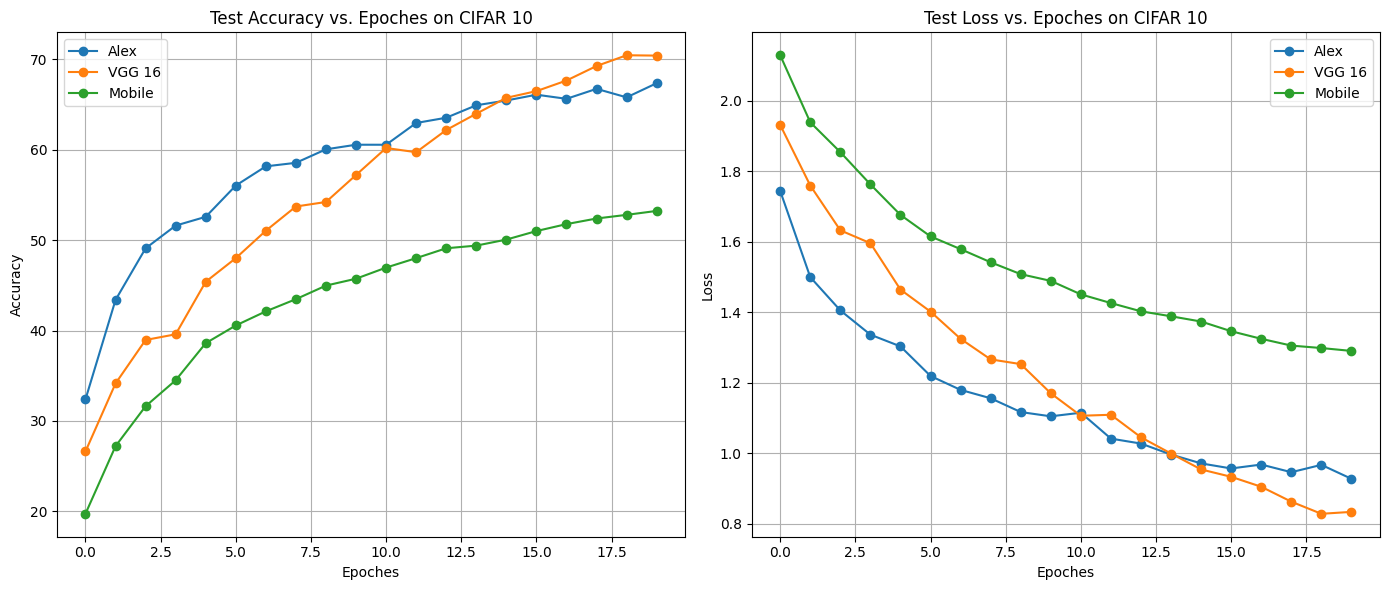

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].plot(history_list_Alex_Cifar10[2]['accuracy'], '-o', label=f"Alex")
axes[0].plot(history_list_VGG_16_Cifar10[1]['accuracy'], '-o', label=f"VGG 16")
axes[0].plot(history_list_Mobile_Cifar10[0]['accuracy'], '-o', label=f"Mobile")

axes[0].set_title(f"Test Accuracy vs. Epoches on CIFAR 10")
axes[0].set_xlabel("Epoches")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_list_Alex_Cifar10[2]['loss'], '-o', label=f"Alex")
axes[1].plot(history_list_VGG_16_Cifar10[1]['loss'], '-o', label=f"VGG 16")
axes[1].plot(history_list_Mobile_Cifar10[0]['loss'], '-o', label=f"Mobile")

axes[1].set_title(f"Test Loss vs. Epoches on CIFAR 10")
axes[1].set_xlabel("Epoches")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

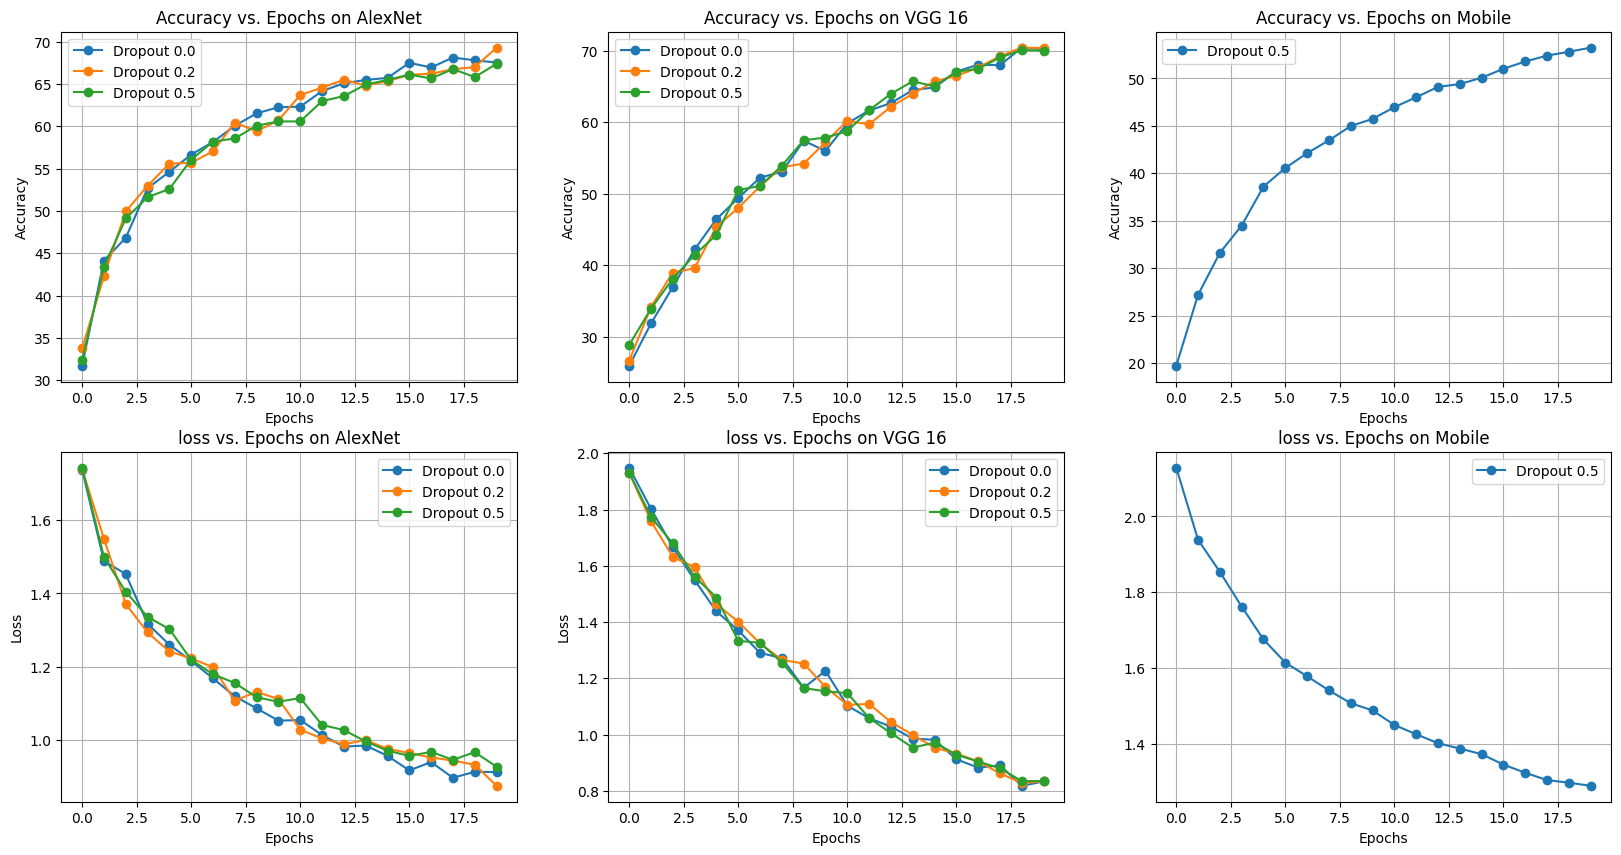

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
dropout_list = [0.0, 0.2, 0.5]

for i, dropout_rate in enumerate (dropout_list):
    axes[0][0].plot(history_list_Alex_Cifar10[i]['accuracy'], '-o', label=f"Dropout {dropout_rate}")
    axes[0][0].set_title(f"Accuracy vs. Epochs on AlexNet")
    axes[0][0].set_xlabel("Epochs")
    axes[0][0].set_ylabel("Accuracy")
    axes[0][0].legend()
    axes[0][0].grid(True)

for i, dropout_rate in enumerate (dropout_list):
    axes[0][1].plot(history_list_VGG_16_Cifar10[i]['accuracy'], '-o', label=f"Dropout {dropout_rate}")
    axes[0][1].set_title(f"Accuracy vs. Epochs on VGG 16")
    axes[0][1].set_xlabel("Epochs")
    axes[0][1].set_ylabel("Accuracy")
    axes[0][1].legend()
    axes[0][1].grid(True)

axes[0][2].plot(history_list_Mobile_Cifar10[0]['accuracy'], '-o', label=f"Dropout {dropout_rate}")
axes[0][2].set_title(f"Accuracy vs. Epochs on Mobile")
axes[0][2].set_xlabel("Epochs")
axes[0][2].set_ylabel("Accuracy")
axes[0][2].legend()
axes[0][2].grid(True)

for i, dropout_rate in enumerate (dropout_list):
    axes[1][0].plot(history_list_Alex_Cifar10[i]['loss'], '-o', label=f"Dropout {dropout_rate}")
    axes[1][0].set_title(f"loss vs. Epochs on AlexNet")
    axes[1][0].set_xlabel("Epochs")
    axes[1][0].set_ylabel("Loss")
    axes[1][0].legend()
    axes[1][0].grid(True)

for i, dropout_rate in enumerate (dropout_list):
    axes[1][1].plot(history_list_VGG_16_Cifar10[i]['loss'], '-o', label=f"Dropout {dropout_rate}")
    axes[1][1].set_title(f"loss vs. Epochs on VGG 16")
    axes[1][1].set_xlabel("Epochs")
    axes[1][1].set_ylabel("Loss")
    axes[1][1].legend()
    axes[1][1].grid(True)

axes[1][2].plot(history_list_Mobile_Cifar10[0]['loss'], '-o', label=f"Dropout {dropout_rate}")
axes[1][2].set_title(f"loss vs. Epochs on Mobile")
axes[1][2].set_xlabel("Epochs")
axes[1][2].legend()
axes[1][2].grid(True)
